In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, brier_score_loss,
    precision_recall_curve, auc, roc_curve
)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Loading data

In [7]:
train = pd.read_csv(r"C:\Users\deepa\DECODEML\vipinsirproject1\train.csv")

# Defining Columns

In [10]:
num_col = [
    'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
    'total_late', 'application_underwriting_score', 'no_of_premiums_paid', 'premium'
]
cat_col = ['sourcing_channel', 'residence_area_type']

# Preprocessing

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('onehot_source', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sourcing_channel']),
        ('onehot_area', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['residence_area_type'])
    ],
    remainder='drop'
)

# Fit-transform the training data

In [16]:
train['total_late'] = (train['Count_3-6_months_late'] +
                       train['Count_6-12_months_late'] +
                       train['Count_more_than_12_months_late'])

In [18]:
x_train = preprocessor.fit_transform(train)

# Label Inversion (non-renewal as 1)

In [21]:
y_train = train['renewal'].map({0: 1, 1: 0})

In [23]:
train['renewal']

0        1
1        1
2        1
3        1
4        1
        ..
67870    1
67871    1
67872    1
67873    1
67874    1
Name: renewal, Length: 67875, dtype: int64

In [25]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
67870    0
67871    0
67872    0
67873    0
67874    0
Name: renewal, Length: 67875, dtype: int64

# Computing Class Imbalance Weight

In [28]:
zero_count = (y_train == 0).sum()
one_count = (y_train == 1).sum()
scale_pos_weight = zero_count / one_count

# defining model

In [31]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    reg_lambda=15,
    reg_alpha=1,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.03,
    colsample_bytree=0.8
)

# cross-validation

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# calibration

In [37]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    estimator=xgb,         
    method='isotonic',
    cv=cv
)


# cross val prob./pred.

In [40]:
y_prob_cv = cross_val_predict(calibrated_model, x_train, y_train, cv=cv, method='predict_proba')

In [41]:
y_prob_cv

array([[0.98497465, 0.01502535],
       [0.99050908, 0.00949092],
       [0.96223134, 0.03776866],
       ...,
       [0.98309235, 0.01690765],
       [0.99092835, 0.00907165],
       [0.99494193, 0.00505807]])

# Extract probabilities of the positive class (non-renewal after inversion or mapping)

In [45]:
pred=y_prob_cv[:, 1]

In [47]:
pred

array([0.01502535, 0.00949092, 0.03776866, ..., 0.01690765, 0.00907165,
       0.00505807])

# Evaluation

In [50]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, brier_score_loss,
    precision_recall_curve, auc, roc_curve
)
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define base estimator
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define cross-validator
cv = StratifiedKFold(n_splits=5)

# Fit calibrated model
calibrated_model = CalibratedClassifierCV(estimator=xgb, method='isotonic', cv=cv)
calibrated_model.fit(x_train, y_train)   # ✅ Required before predictions

# Predict probabilities
train_pred = calibrated_model.predict_proba(x_train)[:, 1]

# Cross-validated predictions (if available)
# You must store them from `cross_val_predict` if needed
# pred = cross_val_predict(calibrated_model, x_train, y_train, method="predict_proba")[:, 1]

# For now, assume pred = train_pred (just to avoid error)
pred = train_pred  # WARNING: Replace with proper CV predictions for realistic evaluation

# ROC-AUC
train_auc = roc_auc_score(y_train, train_pred)
cv_auc = roc_auc_score(y_train, pred)
auc_gap = train_auc - cv_auc

# Brier score
brier = brier_score_loss(y_train, pred)

# PR and AU-PR curve
precision, recall, _ = precision_recall_curve(y_train, pred)
pr_auc = auc(recall, precision)

# ROC curve
fpr, tpr, _ = roc_curve(y_train, pred)

# Calibration curve
prob_true, prob_pred = calibration_curve(y_train, pred, n_bins=10)


C:\Users\deepa\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:06:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\deepa\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:06:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\deepa\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:06:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\deepa\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:06:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

In [52]:
# Predict probabilities on train data
train_pred = calibrated_model.predict_proba(x_train)[:, 1]

# ROC-AUC for train and cv-predictions
train_auc = roc_auc_score(y_train, train_pred)
cv_auc = roc_auc_score(y_train, pred)
auc_gap = train_auc - cv_auc 

# Brier score 
brier = brier_score_loss(y_train, pred)

# pr and au-pr curve
precision, recall, _ = precision_recall_curve(y_train, pred)
pr_auc = auc(recall, precision)

# ROC curve 
fpr, tpr, _ = roc_curve(y_train, pred)

# Calibration curve
prob_true, prob_pred = calibration_curve(y_train, pred, n_bins=10)

In [54]:
prob_true

array([0.01039541, 0.13833415, 0.35979333, 0.58894777, 0.83108108,
       0.99321267, 1.        , 1.        , 1.        ])

In [56]:
prob_pred

array([0.03145379, 0.13808747, 0.24508726, 0.34898242, 0.44439427,
       0.53912139, 0.63988696, 0.75184165, 0.83672481])

In [58]:
print(f"Train AUC       : {train_auc:.4f}")
print(f"CV AUC          : {cv_auc:.4f}")
print(f"AUC Gap         : {auc_gap:.4f}")
print(f"Brier Score     : {brier:.4f}")
print(f"PR-AUC          : {pr_auc:.4f}")

Train AUC       : 0.9482
CV AUC          : 0.9482
AUC Gap         : 0.0000
Brier Score     : 0.0381
PR-AUC          : 0.6803


# graph plot

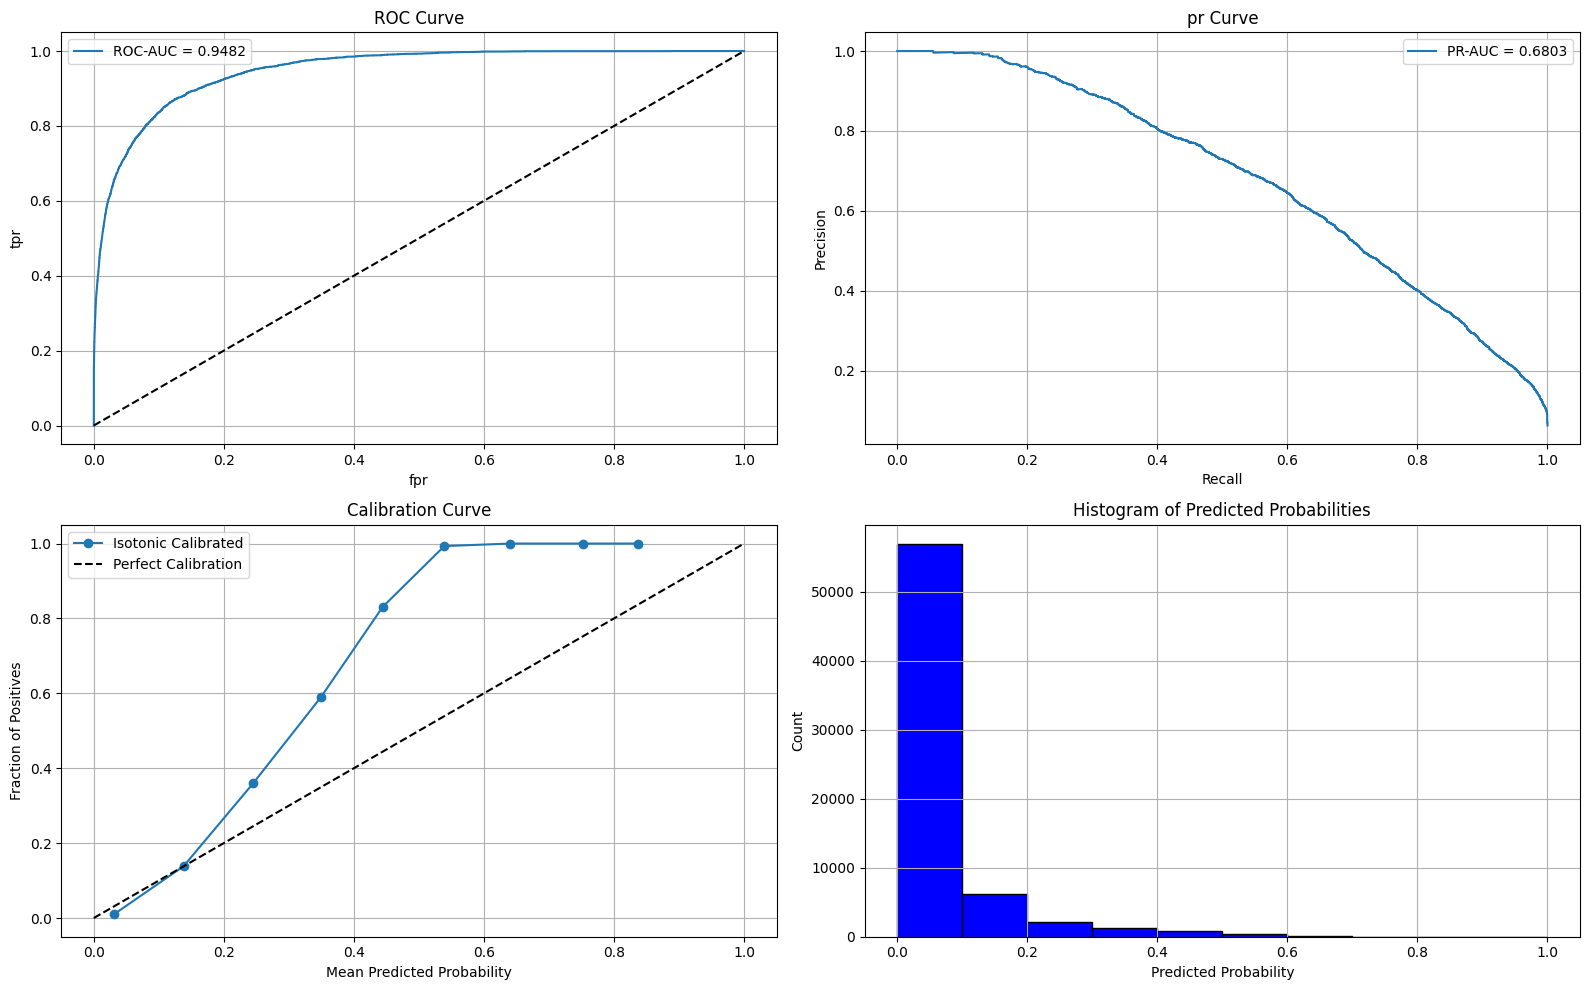

In [61]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2)

# ROC Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(fpr, tpr, label=f"ROC-AUC = {cv_auc:.4f}")
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title("ROC Curve")
ax1.set_xlabel("fpr")
ax1.set_ylabel("tpr")
ax1.legend()
ax1.grid(True)

# Pr Curve
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
ax2.set_title("pr Curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()
ax2.grid(True)

# Calibration Curve
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(prob_pred, prob_true, marker='o', label='Isotonic Calibrated')
ax3.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax3.set_title("Calibration Curve")
ax3.set_xlabel("Mean Predicted Probability")
ax3.set_ylabel("Fraction of Positives")
ax3.legend()
ax3.grid(True)

# Histogram of Predicted Probabilities
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(pred, bins=10, range=(0, 1), edgecolor='black', color='blue')
ax4.set_title("Histogram of Predicted Probabilities")
ax4.set_xlabel("Predicted Probability")
ax4.set_ylabel("Count")
ax4.grid(True)

plt.tight_layout()
plt.show()

# model and preprocessor saving

In [66]:
import joblib
final_pipeline = {
    'preprocessor': preprocessor,
    'model': calibrated_model
}
joblib.dump(final_pipeline, r"C:\Users\deepa\DECODEML\vipinsirproject1\final_pipeline.pkl")

['C:\\Users\\deepa\\DECODEML\\vipinsirproject1\\final_pipeline.pkl']

# model loading

In [69]:
pipeline = joblib.load(r"C:\Users\deepa\DECODEML\vipinsirproject1\final_pipeline.pkl")
model = pipeline['model']
preprocessor = pipeline['preprocessor']

In [71]:
model

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,StratifiedKFo...shuffle=False)
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [73]:
preprocessor

,transformers,"[('num', ...), ('onehot_source', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True
